In [ ]:
### Cell below downloads dataset from GDrive

In [ ]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 3.6 MB/s 


In [ ]:
import requests
import tarfile
import gzip

In [ ]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

file_id = '0BxYys69jI14kYVM3aVhKS1VhRUk'
destination = 'UTKFace.tar.gz'
download_file_from_google_drive(file_id, destination)

tar = tarfile.open('UTKFace.tar.gz' , 'r:gz')
tar.extractall()
tar.close()

ReadError: ignored

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!ls

sample_data  UTKFace.tar.gz


In [ ]:
from IPython.core.debugger import set_trace

from glob import glob
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm as tqdm

from mtcnn.mtcnn import MTCNN ## Multi-task Cascaded Convolutional Neural Networks for Face Detection, based on TensorFlow
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
# Create DataFrame from files
df = pd.DataFrame()
for i, path in enumerate(glob('UTKFace/*jpg')):
    df.loc[i, 'path'] = path
    
for i in tqdm(df.index):
    path = df.loc[i,'path']
    gender = path.split('/')[1].split('_')[1]
    age = path.split('/')[1].split('_')[0]
    etnicity = path.split('/')[1].split('_')[2]
    df.loc[i, 'gender'] = gender
    df.loc[i, 'age'] = age    
    df.loc[i, 'etnicity'] = etnicity

df = df[df.etnicity.apply(lambda x: x.isnumeric())]

df['age'] = df['age'].values.astype('int8')
df['gender'] = df['gender'].values.astype('int8')
df['etnicity'] = df['etnicity'].values.astype('int')
print(df.shape)
print(df.dtypes)
df.describe()


In [ ]:
df.to_pickle('UTKFace_2.0.pkl')


In [ ]:
def resize_img(img, desired_height):
    '''
    Resize image with desired height
    '''
    height, width = img.shape[:2]
    resize_multiple = desired_height/height
    img_height = int(height / resize_multiple)
    img_width = int(height / resize_multiple)
    img = cv2.resize(img, None, fx=resize_multiple, fy=resize_multiple, interpolation=cv2.INTER_AREA)
    return img

def centroid_histogram(clt):
    '''
    Return histogram based on the number of pixels assigned to each cluster.
    '''
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)

    # Normalize the histogram, such that it sums to one.
    hist = hist.astype("float")
    hist /= hist.sum()
    
    return hist

def get_top_colors(hist, centroids):
    '''
    Return the colors with maximum percentage of area covered in descending order.
    '''
    top1 = np.argsort(hist)[-1]
    top2 = np.argsort(hist)[-2]
    top3 = np.argsort(hist)[-3]
    top4 = np.argsort(hist)[-4]

    col1 = np.uint8(centroids[top1])
    col2 = np.uint8(centroids[top2])
    col3 = np.uint8(centroids[top3])
    col4 = np.uint8(centroids[top4])
    
    return col1, col2, col3, col4

def get_face_coords_MTCNN(img):
    detector = MTCNN()
    results = detector.detect_faces(img)
    if results != []:
        b = results[0]['box']
        x1 = int(b[0])
        x1 = (x1 if x1>0 else 0)
        
        y1 = int(b[1]) 
        y1 = (y1 if y1>0 else 0)
        
        x2 = int(b[0]) + int(b[2])
        x2 = (x2 if x2<img.shape[1] else img.shape[1])
        
        y2 = int(b[1]) + int(b[3])
        y2 = (y2 if y2<img.shape[0] else img.shape[0])
        return x1, y1, x2, y2
    else: 
        return None, None, None, None
    
def get_face_coords_DLIB(img):
    faceRects = hogFaceDetector(img, 0)
    if len(faceRects) > 0:
        x1 = faceRects[0].left()
        x1 = (x1 if x1>0 else 0)
        
        y1 = faceRects[0].top()
        y1 = (y1 if y1>0 else 0)
        
        x2 = faceRects[0].right()
        x2 = (x2 if x2<img.shape[1] else img.shape[1])
        
        y2 = faceRects[0].bottom()
        y2 = (y2 if y2<img.shape[0] else img.shape[0])
        return x1, y1, x2, y2
    else: 
        return None, None, None, None
        
        
def get_HSV_centroid(data_ori):
    '''
    Apply clustering alghoritm to HSV image.
    Returns dominant centroids.
    '''
    # Apply k-Means Clustering to the face to obtain most dominant color.
    clt = KMeans(n_clusters = 3, max_iter=5)
    clt.fit(data_ori)
    centroids = clt.cluster_centers_

    # Get the colors with maximum percentage of area covered in descending order.
    hist = centroid_histogram(clt)
    top1 = np.argsort(hist)[-1]
    top2 = np.argsort(hist)[-2]
    top3 = np.argsort(hist)[-3]
    
    col1_hsv = np.uint8([[centroids[top1]]])
    col2_hsv = np.uint8([[centroids[top2]]])
    col3_hsv = np.uint8([[centroids[top3]]])

    # Transform HSV to RGB colorspace
    col1_rgb = cv2.cvtColor(col1_hsv, cv2.COLOR_HSV2RGB)
    col2_rgb = cv2.cvtColor(col2_hsv, cv2.COLOR_HSV2RGB)
    col3_rgb = cv2.cvtColor(col3_hsv, cv2.COLOR_HSV2RGB)
    
    return col1_hsv, col2_hsv, col3_hsv, col1_rgb, col2_rgb, col3_rgb


def get_GRAYscale_centroid(data_ori):
    '''
    Apply clustering alghoritm to GRAY image.
    Returns dominant centroid.
    '''
    # Apply k-Means Clustering to the face to obtain most dominant color.
    clt = KMeans(n_clusters = 3, max_iter=20, n_init=3)
    clt.fit(data_ori)
    centroids = clt.cluster_centers_

    # Get the colors with maximum percentage of area covered in descending order.
    hist = centroid_histogram(clt)
    top1 = np.argsort(hist)[-1]
    top2 = np.argsort(hist)[-2]
    top3 = np.argsort(hist)[-3]

    col1_gray = np.uint8(centroids[top1])
    col2_gray = np.uint8(centroids[top2])
    col3_gray = np.uint8(centroids[top3])
    return col1_gray, col2_gray, col3_gray
    

def get_colors(img_path, show_gray=False, show_rgb=False):
    img = cv2.imread(img_path)
    img = resize_img(img, 720)
    # 1. Detect the face coords and take out the face from the image
    face_bb = get_face_coords_MTCNN(img)
    x1, y1, x2, y2 = face_bb
    
    if x1 == None:
        return np.nan, np.nan, np.nan, np.nan
    
    # Crop face from image 
    face = img[y1:y2,x1:x2]
    face = resize_img(face, 50)
    
    # 2. Convert to HSV, Reshape image data to the flatten array and apply K-means to HSV image
    face_hsv = cv2.cvtColor(face, cv2.COLOR_BGR2HSV)
    data = face_hsv.reshape((face_hsv.shape[0] * face_hsv.shape[1], 3))
    
    # 3. Apply k-Means Clustering to the face to obtain most dominant color
    col1_hsv, col2_hsv, col3_hsv, col1_rgb, col2_rgb, col3_rgb = get_HSV_centroid(data)
    

    # Same steps for grayscale image
    face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
    data = face_gray.reshape((face_gray.shape[0] * face_gray.shape[1], 1))
    col1_gray, col2_gray, col3_gray = get_GRAYscale_centroid(data)
    
    # Show images
    if show_rgb == True:
        lo_square1 = np.full((10, 10, 3), col1_rgb, dtype=np.uint8)
        lo_square2 = np.full((10, 10, 3), col2_rgb, dtype=np.uint8)
        lo_square3 = np.full((10, 10, 3), col3_rgb, dtype=np.uint8)
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(5, 5))

        # print(col1_rgb, col2_rgb, col3_rgb)
        ax1.imshow(face[:,:,[2,1,0]])
        ax2.imshow(lo_square1)
        ax3.imshow(lo_square2)
        ax4.imshow(lo_square3)
        plt.show()
    
    if show_gray == True:
        lo_square1 = np.full((10, 10), col1_gray, dtype=np.uint8)
        lo_square2 = np.full((10, 10), col2_gray, dtype=np.uint8)
        lo_square3 = np.full((10, 10), col3_gray, dtype=np.uint8)
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(5, 5))
        print(col1_gray, col2_gray, col3_gray)
    
        ax1.imshow(face_gray, cmap='gray', vmin=0, vmax=255)
        ax2.imshow(lo_square1, cmap='gray', vmin=0, vmax=255)
        ax3.imshow(lo_square2, cmap='gray', vmin=0, vmax=255)
        ax4.imshow(lo_square3, cmap='gray', vmin=0, vmax=255)
        plt.show()
    
    return col1_hsv[0][0], col1_rgb[0][0], col1_gray, face_bb
  

In [ ]:
for i in tqdm(df.index[:5]):
    img_path = df.at[i, 'path']
    col1_hsv, col1_rgb, col1_gray, face_bb = get_colors(img_path, show_gray=True)

for i in tqdm(df.index[:5]):
    img_path = df.at[i, 'path']
    col1_hsv, col1_rgb, col1_gray, face_bb = get_colors(img_path, show_rgb=True)
    
    

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
df['hsv_color'] = None
df['hsv_color'] = df['hsv_color'].astype(object)
df['rgb_color'] = None
df['rgb_color'] = df['rgb_color'].astype(object)
df['gray_color'] = None
df['gray_color'] = df['gray_color'].astype(object)
df['face_bb'] = None
df['face_bb'] = df['face_bb'].astype(object)

for i in tqdm(df.index[:]):
    try:
        img_path = df.at[i, 'path']
        col1_hsv, col1_rgb, col1_gray, face_bb = get_colors(img_path)

        df.at[i, 'hsv_color'] = col1_hsv
        df.at[i, 'rgb_color'] = col1_rgb
        df.at[i, 'gray_color'] = col1_gray
        df.at[i, 'face_bb'] = face_bb
    except Exception as ex:
         print(ex)

df.to_pickle('UTKFace_2.0.pkl')


0it [00:00, ?it/s]

In [ ]:
df.head()

,hsv_color,rgb_color,gray_color,face_bb


In [ ]:
from google.colab import files
files.download('UTKFace_2.0.pkl')

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();
    
      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  
  return filename

In [ ]:
def colorCorrection(path):
  outDir = "/content/sample_data/output/"
  # Check whether the specified path exists or not
  isExist = os.path.exists(outDir)

  if not isExist:
    # Create a new directory because it does not exist 
    os.makedirs(outDir)

  #Calulate Mean of the respective Channels
  InputImage = cv2.imread(path)
  InputImage = InputImage.astype(np.uint8)

  # Allocate memory for the image
  outputImage = np.zeros((InputImage.shape[1-1],InputImage.shape[2-1],3))
  
  #Mean of the Red, Green and Blue channels
  meanRedChannel = np.mean(np.mean(InputImage[::1]))
  meanGreenChannel = np.mean(np.mean(InputImage[::2]))
  meanBlueChannel = np.mean(np.mean(InputImage[::3]))
  
  #Calulate Light L components
  LRed = meanRedChannel / 128
  Lblue = meanBlueChannel / 128
  LGreen = meanGreenChannel / 128
  
  #White Balance Image
  outputImage[:, :, 0] = InputImage[:, :, 0] * (0.9 / LRed)
  outputImage[:, :, 1]  = InputImage[:, :, 1] * (0.9 / LGreen)
  outputImage[:, :, 2] = InputImage[:, :, 2] * (0.9 / Lblue)
  
  outputImage = outputImage.astype(np.uint8)
  outimageName = 'corrected.jpg'
  outimageName = os.path.join(outDir, outimageName)
  cv2.imwrite(str(outimageName),outputImage)
  return outimageName

In [ ]:
def skinType(skinValue):
  skType = ["Light", "Light Medium", "Medium","Medium Deep","Deep"]
  if skinValue < 105.0:
    return skType[4]
  elif skinValue < 150.0:
    return skType[3]
  elif skinValue < 195.0:
    return skType[2]
  elif skinValue < 240.0:
    return skType[1]
  elif skinValue < 255.0:
    return skType[0]

In [ ]:
from IPython.display import Image
import os
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  # img_path = colorCorrection(filename)
  col1_hsv, col1_rgb, col1_gray, face_bb = get_colors(filename, show_gray=True)
  
  # img_path2 = colorCorrection(filename)
  col2_hsv, col2_rgb, col2_gray, face2_bb = get_colors(filename, show_rgb=True)
  print(skinType(col2_rgb[0]))
  
  print(col2_rgb)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

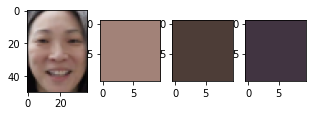

Medium


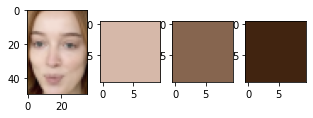

Light Medium


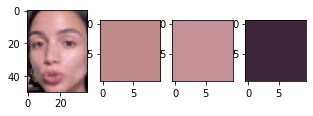

Medium


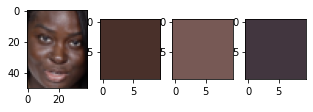

Deep


In [ ]:
import numpy as np
import glob
from IPython.display import Image, display
import math

for imageName in glob.glob('/content/sample_data/TikTok/*.png'):
    col2_hsv, col2_rgb, col2_gray, face_bb = get_colors(imageName, show_rgb=True)
    print(skinType(col2_rgb[0]))

In [ ]:
import cv2
# from google.colab import drive
# drive.mount('/content/drive')
video_name = "/content/sample_data/tiktok1.mp4" # or any other extension like .avi etc
vidcap = cv2.VideoCapture(video_name)
success,image = vidcap.read()
count = 0

while success:
  cv2.imwrite("/content/sample_data/YouTube/frame%d.jpg" % count, image)    # save frame as JPEG file      
  success,image = vidcap.read()
  count += 1

print('end')

In [ ]:
skTypes = {"Light":0, "Light Medium":1, "Medium":2,"Medium Deep":3,"Deep":4}
color = [0,0,0,0,0]
count2 = count
# (color * 100) / count
import numpy as np
import glob
from IPython.display import Image, display
import math

for imageName in glob.glob('/content/sample_data/YouTube/*.jpg'):
    col2_hsv, col2_rgb, col2_gray, face_bb = get_colors(imageName, show_rgb=False)
    if type(col2_rgb) != float:
      col = col2_rgb[0]
      skn = skinType(col)
      color[skTypes[skn]] += 1
    else:
      count -= 1
    count2 -= 1
    if count2 == 0:
      break
print("end")
avgColorL = (color[0] * 100 ) / count
avgColorLM = (color[1] * 100 ) / count
avgColorM = (color[2] * 100 ) / count
avgColorMD = (color[3] * 100 ) / count
avgColorD = (color[4] * 100 ) / count

In [ ]:
!pip install tabulate
from tabulate import tabulate

In [ ]:
data = [
        ["Light", avgColorL],
        ["Light Medium", avgColorLM],
        ["Medium", avgColorM],
        ["Medium Deep", avgColorMD],
        ["Deep", avgColorD]
]

col_names = ["Tom de Pele", "%"]
print(tabulate(data, headers=col_names, tablefmt="grid", showindex="always"))